<a href="https://colab.research.google.com/github/NShah19/QuantumProgramming/blob/main/BernsteinVazirani/bernstein_vazirani.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install Cirq & Import Libraries/Modules

In [1]:
!pip install git+https://github.com/quantumlib/Cirq.git --quiet

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 1.3MB 4.3MB/s 


In [2]:
import cirq
import time
import random
import numpy as np
import matplotlib.pyplot as plt

## Set Parameters (user input)

In [3]:
# Define input length
n_qubits = 10
n_repititions = 10

## Build U_f and Assemble Circuit

In [4]:
# Assign qubits
def assign_qubits(n_qubits):
  input = [cirq.LineQubit(i) for i in range(n_qubits)]
  helper = cirq.LineQubit(n_qubits)
  return input, helper

In [5]:
# Assign random values for the coefficient a, and the bias b
def create_secret_func(n_qubits):
  a = [random.randint(0,1) for _ in range(n_qubits)]
  b = random.randint(0,1)
  return a, b

In [6]:
def print_input_func(a, b):
  """ Print Berstein-Vazirani input function"""
  print('Input Function:\nf(x) = <{}>·x + {} (mod 2)'.format(', '.join(str(i) for i in a), b))

In [7]:
def make_BV_Uf(input, helper, a, b):
  """ Make Berstein-Vazirani U_f """
  if helper:
    yield cirq.X(helper)

  for qubit, bit in zip(input, a):
    if bit:
      yield cirq.CNOT(qubit, helper)

In [8]:
def make_circuit(input, helper, Uf):
  """ Assemble quantum circuit for Deutsch-Josza/Berstein-Vazirani """
  # Initialize inputs in superposition
  circuit = cirq.Circuit()
  circuit.append(
      [
       cirq.X(helper), 
       cirq.H(helper), 
       cirq.H.on_each(*input)
      ], 
      strategy=cirq.InsertStrategy.NEW_THEN_INLINE)
 
  # Append U_f
  circuit.append(Uf)

  # Apply H on all input qubits and measure
  circuit.append(
      [
       cirq.H.on_each(*input),
       cirq.measure(*input, key='a')
      ],
      strategy=cirq.InsertStrategy.NEW_THEN_INLINE)

  return circuit

In [9]:
# Helper function.
def bitstring(bits):
    return "".join(str(int(b)) for b in bits)

In [13]:
def print_output(a, b, circuit, result):
  print_input_func(a, b)
  print('Circuit:\n')
  print(circuit)

  # Look at the sampled bitstrings.
  frequencies = result.histogram(key="a", fold_func=bitstring)
  print('Sampled results:\n{}'.format(frequencies))

  # Check if we actually found the value of a
  most_common_bitstring = frequencies.most_common(1)[0][0]
  print('Most common bitstring: {}\n'.format(most_common_bitstring))
  print('Found a match: {}'.format(most_common_bitstring == bitstring(a)))

## Run Bernstein-Vazirani

In [14]:
def run_bernstein_vazirani(n_qubits, n_repititions):
  input, helper = assign_qubits(n_qubits)
  a, b = create_secret_func(n_qubits)
  U_f = make_BV_Uf(input, helper, a, b)
  circuit = make_circuit(input, helper, U_f)
  simulator = cirq.Simulator()
  result = simulator.run(circuit, repetitions=n_repititions)
  print_output(a, b, circuit, result)

In [15]:
run_bernstein_vazirani(n_qubits, n_repititions)

Input Function:
f(x) = <1, 1, 0, 0, 1, 0, 0, 1, 0, 0>·x + 1 (mod 2)
Circuit:

0: ────────H───────@───────────────H───M('a')───
                   │                   │
1: ────────H───────┼───@───────────H───M────────
                   │   │               │
2: ────────H───────┼───┼───────────H───M────────
                   │   │               │
3: ────────H───────┼───┼───────────H───M────────
                   │   │               │
4: ────────H───────┼───┼───@───────H───M────────
                   │   │   │           │
5: ────────H───────┼───┼───┼───────H───M────────
                   │   │   │           │
6: ────────H───────┼───┼───┼───────H───M────────
                   │   │   │           │
7: ────────H───────┼───┼───┼───@───H───M────────
                   │   │   │   │       │
8: ────────H───────┼───┼───┼───┼───H───M────────
                   │   │   │   │       │
9: ────────H───────┼───┼───┼───┼───H───M────────
                   │   │   │   │
10: ───X───H───X───X───X───X──

## **Simulation and Testing**

In [15]:
num_qubits = np.linspace(1, 25, 25, dtype=int)
end_times = {}
for num in num_qubits:
  inputs, helper = assign_qubits(num)
  a, b = create_secret_func(num)
  U_f = make_BV_Uf(inputs, helper, a, b)
  circuit = make_circuit(inputs, helper, U_f)
  simulator = cirq.Simulator()
  start_time = time.time()
  result = simulator.run(circuit, repetitions=n_repititions)
  et = time.time() - start_time
  print_output(a, b, circuit, result)
  print("--- %s seconds ---" % (et))
  if num not in end_times:
    end_times[num] = [et]
  else:
    end_times[num].append(et)
print(end_times)

Input Function:
f(x) = <1>·x + 1 (mod 2)
Circuit:

0: ───────H───────@───H───M('a')───
                  │
1: ───X───H───X───X────────────────
Sampled results:
Counter({'1': 10})
Most common bitstring: 1

Found a match: True
--- 0.0032966136932373047 seconds ---
Input Function:
f(x) = <1, 0>·x + 1 (mod 2)
Circuit:

0: ───────H───────@───H───M('a')───
                  │       │
1: ───────H───────┼───H───M────────
                  │
2: ───X───H───X───X────────────────
Sampled results:
Counter({'10': 10})
Most common bitstring: 10

Found a match: True
--- 0.00500035285949707 seconds ---
Input Function:
f(x) = <1, 0, 0>·x + 0 (mod 2)
Circuit:

0: ───────H───────@───H───M('a')───
                  │       │
1: ───────H───────┼───H───M────────
                  │       │
2: ───────H───────┼───H───M────────
                  │
3: ───X───H───X───X────────────────
Sampled results:
Counter({'100': 10})
Most common bitstring: 100

Found a match: True
--- 0.007359743118286133 seconds ---
Input F

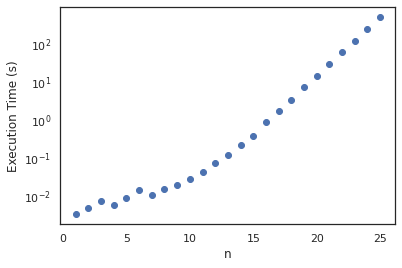

In [23]:
lists = sorted(end_times.items())
x ,y = zip(*lists)
plt.xlabel('n')
plt.ylabel('Execution Time (s)')
plt.scatter(x, y)
plt.yscale('log')
plt.show()